In [1]:
import re
import numpy as np
from collections import Counter

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#todo: increase doc collections: news dataset 
doc = {
    0: "quick brown fox jumps over the lazy dog", 
    1: "bank is near the bank hello is a"
}

In [3]:
def text_preprocess(text):
    text = re.sub(r'[^a-zA-Z]+', ' ', text).strip()
    text = re.sub(' +', ' ', text)
    text = text.split(' ')
    text = [w.lower() for w in text]
    return text

vocabulary = []
for k, d in doc.items():
    doc[k] = text_preprocess(d)
    vocabulary.extend(doc[k])

In [4]:
vocabulary = list(set(vocabulary))

In [5]:
D = len(doc)
K = 2
V = len(vocabulary)


c = np.zeros([D, K])
n = np.zeros([K, V])
C = np.zeros(D)
N = np.zeros(K)

In [6]:
Z = []
W = []

for k, v in doc.items():
    W.append(np.array(v))
    z = np.array([np.random.choice(K, 1)[0] for i in v])
    Z.append(z)

Z = np.array(Z)
W = np.array(W)

In [7]:
n

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [8]:
def update(c, n, C, N):
    for d, _ in doc.items():
        k_count_in_a_doc = Counter(Z[d])
        
        C_d = 0
        
        for k in range(K):
            c[d][k] = k_count_in_a_doc[k]
            C_d += k_count_in_a_doc[k]
            
        C[d] = C_d
        
    for k in range(K):
        W_k = [] 
        
        for key, _ in doc.items():
            index = np.where(Z[key] == k)[0]
            
            if len(index)>0:
                W_k.extend(W[key][index])
                
        count = Counter(W_k)
        
        for v in range(V):
            n[k][v] = count[vocabulary[v]]
            
        N[k] = len(W_k)

In [9]:
update(c, n, C, N)

In [10]:
n

array([[1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.],
       [0., 1., 1., 0., 1., 0., 0., 2., 1., 1., 0., 0., 1.]])

Algorithm

In [11]:
A = 0.1
B = 0.1 
total_performance = []


for _ in range(100):
    performance = [] 

    for d, v in doc.items():
        for w in range(len(v)):
            k_word = Z[d][w]
            i_word = vocabulary.index(doc[d][w])

            c[d][k_word] = c[d][k_word] - 1

            n[k_word][i_word] = n[k_word][i_word] - 1 


            prob_k = []

            for k in range(K):
                dt_term = (c[d][k] + A/K) / (C[d] + A - 1)

                if N[k] == 0: 
                    N[k] += 1 
                tw_term = (n[k][i_word] + B/V) / (N[k] + B - 1)

                prob_k.append(dt_term * tw_term)
            
            performance.append(np.log(np.sum(prob_k)))


            total_prob = np.sum(prob_k)

            prob_k = [p/total_prob for p in prob_k]

            Z[d][w] = np.random.choice(K, 1, p=prob_k)[0]

            update(c, n, C, N)
    total_performance.append(np.sum(performance))


In [12]:
n

array([[1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.],
       [0., 2., 0., 0., 2., 0., 1., 2., 0., 1., 0., 1., 0.]])

In [13]:
N

array([7., 9.])

### topic word distribution visualisation

In [14]:
topic_word_dist = {} 

for k in range(K):
    assign_word_in_topic = []
    
    for key, _ in doc.items():
        index = np.where(Z[key] == k)[0]
        
        if len(index) > 0:
            assign_word_in_topic.extend(W[key][index])

    count = Counter(assign_word_in_topic)
    total = np.sum(list(count.values()))
    
    topic_word_dist[k] = [round(count[vocabulary[v]]/total, 2) for v in range(V)]

In [15]:
topic_word_dist

{0: [0.14, 0.0, 0.14, 0.14, 0.0, 0.14, 0.0, 0.0, 0.14, 0.0, 0.14, 0.0, 0.14],
 1: [0.0, 0.22, 0.0, 0.0, 0.22, 0.0, 0.11, 0.22, 0.0, 0.11, 0.0, 0.11, 0.0]}

In [ ]:
for i in topic_word_dist:
    

Text(0.5, 1.0, 'Topic word distribution')

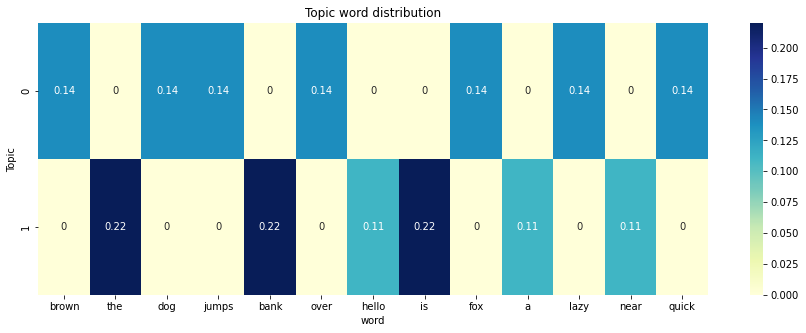

In [21]:
df = pd.DataFrame(topic_word_dist).T
df.columns = vocabulary

plt.figure(figsize=(15,5))
sns.heatmap(df, annot=True, cmap='YlGnBu')
plt.xlabel('word')
plt.ylabel('Topic')
plt.title('Topic word distribution')

In [22]:
df

,brown,the,dog,jumps,bank,over,hello,is,fox,a,lazy,near,quick
0,0.14,0.00,0.14,0.14,0.00,0.14,0.00,0.00,0.14,0.00,0.14,0.00,0.14
1,0.00,0.22,0.00,0.00,0.22,0.00,0.11,0.22,0.00,0.11,0.00,0.11,0.00


### Document topic distribution Visualisation

In [17]:
doc_topic_dist = {}

for key, _ in doc.items():
    count = Counter(Z[key])
    
    total = np.sum(list(count.values()))
    
    doc_topic_dist[key] = [count[k]/total for k in range(K)]

Text(0.5, 1.0, 'Document topic distribution')

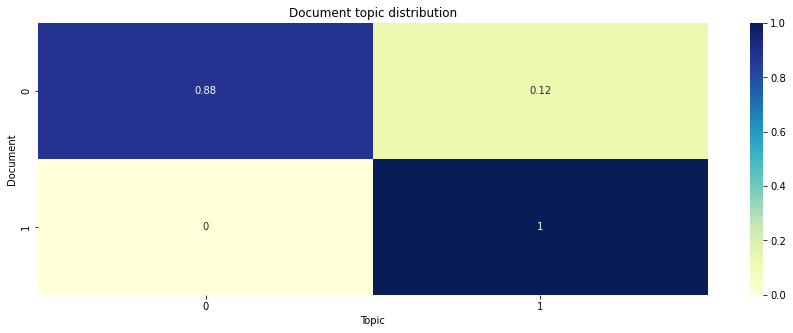

In [18]:
df = pd.DataFrame(doc_topic_dist).T

plt.figure(figsize=(15,5))
sns.heatmap(df, annot=True, cmap='YlGnBu')
plt.xlabel('Topic')
plt.ylabel('Document')
plt.title('Document topic distribution')